In [1]:
timm_path = "../input/timm-pytorch-image-models/pytorch-image-models-master"
import sys
sys.path.append(timm_path)
import timm
import torch

In [2]:
import torch.nn as nn
import torchvision
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection import FasterRCNN
from collections import OrderedDict
from torchvision.models.detection.backbone_utils import BackboneWithFPN
from typing import Callable, Dict, Optional, List, Union
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork, LastLevelMaxPool, ExtraFPNBlock
from torch import nn, Tensor
from torchvision.models._utils import IntermediateLayerGetter
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import time
import shutil
import torch.nn as nn
from skimage import io
import torchvision
import cv2
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset


In [3]:
class My_BackboneWithFPN(nn.Module):
    def __init__(
        self,
        backbone: nn.Module,
        return_layers: Dict[str, str],
        in_channels_list: List[int],
        out_channels: int,
        extra_blocks: Optional[ExtraFPNBlock] = None,
    ) -> None:
        super().__init__()

        if extra_blocks is None:
            extra_blocks = LastLevelMaxPool()
        
        self.backbone = backbone
        self.back = self.backbone.blocks
        

        self.body = IntermediateLayerGetter(self.back, return_layers=return_layers)
        self.fpn = FeaturePyramidNetwork(
            in_channels_list=in_channels_list,
            out_channels=out_channels,
            extra_blocks=extra_blocks,
        )
        self.out_channels = out_channels
        
        

    def forward(self, x: Tensor) -> Dict[str, Tensor]:
        x = self.backbone.conv_stem(x)
        x = self.backbone.bn1(x)
        x = self.backbone.act1(x) 
        x = self.body(x)
        x = self.fpn(x)
        return x

In [4]:
def custom_fpn(backbone,pretrained):
    
    in_channels_list = [32, 48, 136, 384]
    backbone = timm.create_model(backbone, pretrained=pretrained,num_classes=0, global_pool='')
    out_channels = 384
    return_layers = {'1':'0', '2': '1', '4': '2', '6': '3'}
    
    return My_BackboneWithFPN(backbone, return_layers, in_channels_list, out_channels)

In [5]:
# mm = timm.create_model("efficientnet_b7", pretrained=True,num_classes=0, global_pool='')

In [6]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
BASE_DIR = "../input/tensorflow-great-barrier-reef/train_images/"

NUM_EPOCHS = 10

In [7]:
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.backbone_utils import BackboneWithFPN
def get_model():
    # load a model; pre-trained on COCO
    #model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    #backbone
    back = custom_fpn("efficientnet_b3" , True)
    
    #RPN
    anchor_sizes = ((8,),(32,), (64,), (128,), (256,),)
    aspect_ratios = ((0.5, 1.0,),) * len(anchor_sizes)
    anchor_generator = AnchorGenerator(anchor_sizes, aspect_ratios)
    
    #ROI
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0','1','2','3','pool'],
                output_size=7,
                sampling_ratio=2)
    
    model = FasterRCNN(back,num_classes=2,rpn_anchor_generator=anchor_generator,box_roi_pool=roi_pooler)
    model.to(DEVICE)
    return model

model = get_model()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b3_ra2-cf984f9c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_ra2-cf984f9c.pth


In [8]:
# images, boxes = torch.rand(2, 3, 400, 400).to(device), torch.rand(2, 11, 4).to(device)
# boxes[:, :, 2:4] = boxes[:, :, 0:2] + boxes[:, :, 2:4]
# labels = torch.randint(0, 2, (4, 11)).to(device)
# images = list(image for image in images)
# targets = []
# for i in range(len(images)):
#     d = {}
#     d['boxes'] = boxes[i]
#     d['labels'] = labels[i]
#     targets.append(d)

In [9]:
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
# model = model.to(device)

In [10]:
# reading the train csv
train_df = pd.read_csv("../input/tensorflow-great-barrier-reef/train.csv")

# converts the string annots to list
train_df['annotations'] = train_df['annotations'].apply(eval) 

# creating new column "img_path"
func = lambda x: "video_"+x.split("-")[0]+"/"+x.split("-")[1]+".jpg"
train_df["img_path"] = train_df["image_id"].apply(func)

# getting only the entries which has bboxes
train_df["no_of_bbox"] = train_df["annotations"].apply(lambda x: len(x))
train_df = train_df[train_df["no_of_bbox"]>0].reset_index(drop=True)
train_df.head(6)

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,img_path,no_of_bbox
0,0,40258,16,16,0-16,"[{'x': 559, 'y': 213, 'width': 50, 'height': 32}]",video_0/16.jpg,1
1,0,40258,17,17,0-17,"[{'x': 558, 'y': 213, 'width': 50, 'height': 32}]",video_0/17.jpg,1
2,0,40258,18,18,0-18,"[{'x': 557, 'y': 213, 'width': 50, 'height': 32}]",video_0/18.jpg,1
3,0,40258,19,19,0-19,"[{'x': 556, 'y': 214, 'width': 50, 'height': 32}]",video_0/19.jpg,1
4,0,40258,20,20,0-20,"[{'x': 555, 'y': 214, 'width': 50, 'height': 32}]",video_0/20.jpg,1
5,0,40258,21,21,0-21,"[{'x': 550, 'y': 214, 'width': 50, 'height': 32}]",video_0/21.jpg,1


In [11]:
class ReefDataset:

    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms

    def can_augment(self, boxes):
        box_outside_image = ((boxes[:, 0] < 0).any() or (boxes[:, 1] < 0).any() 
                             or (boxes[:, 2] > 1280).any() or (boxes[:, 3] > 720).any())
        return not box_outside_image

    def get_boxes(self, row):
        """Returns the bboxes for a given row as a 3D matrix with format [x_min, y_min, x_max, y_max]"""
        
        boxes = pd.DataFrame(row['annotations'], columns=['x', 'y', 'width', 'height']).astype(np.float32).values
        
        # Change from [x_min, y_min, w, h] to [x_min, y_min, x_max, y_max]
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        return boxes
    
    def get_image(self, row):
        """Gets the image for a given row"""
        
        image = cv2.imread(f'{BASE_DIR}/{row["image_path"]}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        return image
    
    def __getitem__(self, i):

        row = self.df.iloc[i]
        
        image = cv2.imread(f'{BASE_DIR}/{row["img_path"]}', cv2.IMREAD_COLOR)
#         print(f'{BASE_DIR}/{row["img_path"]}')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /=255.0
        
        
        boxes = pd.DataFrame(row['annotations'], columns=['x', 'y', 'width', 'height']).astype(np.float32).values
        
        # Change from [x_min, y_min, w, h] to [x_min, y_min, x_max, y_max]
#         boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
#         boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        boxes[:, 2] = np.clip(boxes[:, 0] + boxes[:, 2],0,1280)
        boxes[:, 3] = np.clip(boxes[:, 1] + boxes[:, 3],0,720)
        
        n_boxes = boxes.shape[0]
        
        # Calculate the area
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        
        target = {
            'boxes': torch.as_tensor(boxes, dtype=torch.float32),
            'area': torch.as_tensor(area, dtype=torch.float32),
            
            'image_id': torch.tensor([i]),
            
            
            'labels': torch.ones((n_boxes,), dtype=torch.int64),
            
            
            'iscrowd': torch.zeros((n_boxes,), dtype=torch.int64)            
        }

        if self.transforms and self.can_augment(boxes):
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': target['labels']
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            if n_boxes > 0:
                target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
        else:
            image = ToTensorV2(p=1.0)(image=image)['image']

        return image, target

    def __len__(self):
        return len(self.df)

In [12]:
df_train = train_df.iloc[0: 1200]
df_val = train_df.iloc[1201:1250]

ds_train = ReefDataset(df_train)
ds_val = ReefDataset(df_val)

# df_train = train_df.iloc[0: 1200]
# df_val = train_df.iloc[1201:1250]

# ds_train = ReefDataset(df_train)
# ds_val = ReefDataset(df_val)

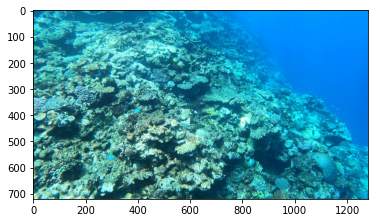

In [13]:
image, targets = ds_train[200]
# image = image.permute(2,1,0).numpy()
# plt.imshow(image)
img = image.permute(1,2,0).cpu().numpy()
# plt.imshow(image.numpy().reshape((720, 1280,3)))
plt.imshow(img)

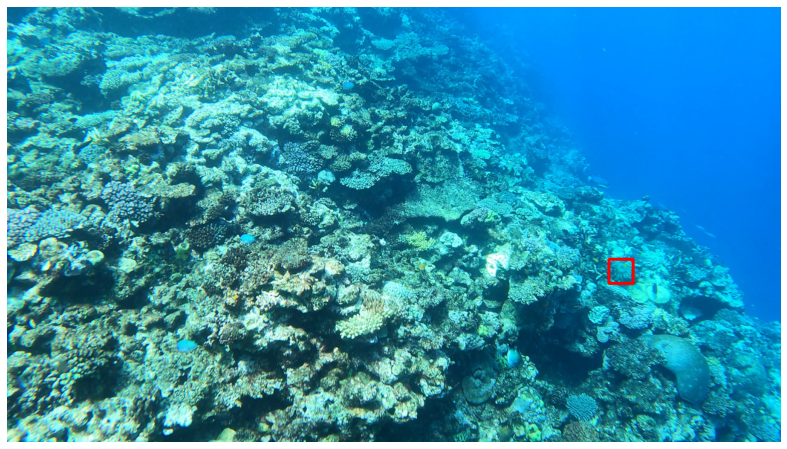

In [14]:
boxes = targets['boxes'].cpu().numpy().astype(np.int32)
img = image.permute(1,2,0).cpu().numpy()
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(img,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(img);

In [15]:
def collate_fn(batch):
    return tuple(zip(*batch))

dl_train = DataLoader(ds_train, batch_size=2, shuffle=False, num_workers=4, collate_fn=collate_fn)
dl_val = DataLoader(ds_val, batch_size=2, shuffle=False, num_workers=4, collate_fn=collate_fn)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [16]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0025, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

n_batches, n_batches_val = len(dl_train), len(dl_val)
validation_losses = []


for epoch in range(NUM_EPOCHS):
    time_start = time.time()
    loss_accum = 0
    
    for batch_idx, (images, targets) in enumerate(dl_train, 1):
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        # Predict
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_accum += loss_value

        # Back-prop
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    # Validation 
    val_loss_accum = 0
        
    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(dl_val, 1):
            images = list(image.to(DEVICE) for image in images)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
            
            val_loss_dict = model(images, targets)
            val_batch_loss = sum(loss for loss in val_loss_dict.values())
            val_loss_accum += val_batch_loss.item()
    
    # Logging
    val_loss = val_loss_accum / n_batches_val
    train_loss = loss_accum / n_batches
    validation_losses.append(val_loss)
    
    # Save model
    chk_name = f'fasterrcnn_resnet50_fpn-e{epoch}.bin'
    torch.save(model.state_dict(), chk_name)
    
    
    elapsed = time.time() - time_start
    
    print(f"[Epoch {epoch+1:2d} / {NUM_EPOCHS:2d}] Train loss: {train_loss:.3f}. Val loss: {val_loss:.3f} --> {chk_name}  [{elapsed:.0f} secs]")   

[Epoch  1 / 10] Train loss: 0.072. Val loss: 0.051 --> fasterrcnn_resnet50_fpn-e0.bin  [348 secs]
[Epoch  2 / 10] Train loss: 0.062. Val loss: 0.048 --> fasterrcnn_resnet50_fpn-e1.bin  [344 secs]
[Epoch  3 / 10] Train loss: 0.060. Val loss: 0.046 --> fasterrcnn_resnet50_fpn-e2.bin  [345 secs]
[Epoch  4 / 10] Train loss: 0.054. Val loss: 0.047 --> fasterrcnn_resnet50_fpn-e3.bin  [345 secs]
[Epoch  5 / 10] Train loss: 0.051. Val loss: 0.055 --> fasterrcnn_resnet50_fpn-e4.bin  [345 secs]
[Epoch  6 / 10] Train loss: 0.048. Val loss: 0.053 --> fasterrcnn_resnet50_fpn-e5.bin  [346 secs]
[Epoch  7 / 10] Train loss: 0.044. Val loss: 0.055 --> fasterrcnn_resnet50_fpn-e6.bin  [345 secs]
[Epoch  8 / 10] Train loss: 0.042. Val loss: 0.052 --> fasterrcnn_resnet50_fpn-e7.bin  [346 secs]
[Epoch  9 / 10] Train loss: 0.039. Val loss: 0.051 --> fasterrcnn_resnet50_fpn-e8.bin  [346 secs]
[Epoch 10 / 10] Train loss: 0.039. Val loss: 0.053 --> fasterrcnn_resnet50_fpn-e9.bin  [345 secs]
